# ДЗ_6: Опанування класифікації зображень: Створення моделі глибокого навчання для розпізнавання природних сцен

In [1]:
# Fastai modules
from fastai.vision.all import *
from fastai.metrics import error_rate

# Torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OpenCV for image processing
import cv2

# File and path handling
import os
from pathlib import Path

# KaggleHub integration
import kagglehub

# Evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", dataset_path)


Path to dataset files: /Users/julia/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [4]:
path = Path(dataset_path)
train_path = path / 'seg_train' / 'seg_train'
test_path = path / 'seg_test' / 'seg_test'
pred_path = path / 'seg_pred'


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data = datasets.ImageFolder(root=test_path, transform=val_test_transform)
pred_data = datasets.ImageFolder(root=pred_path, transform=val_test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
pred_loader = DataLoader(pred_data, batch_size=batch_size, shuffle=False)


In [7]:
def denormalize(image):
    image = image * 0.5 + 0.5
    return image

def visualize_augmentations(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        image = images[i]
        label = labels[i]

        image = denormalize(image)

        np_image = image.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

        ax.imshow(np_image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")
    plt.show()


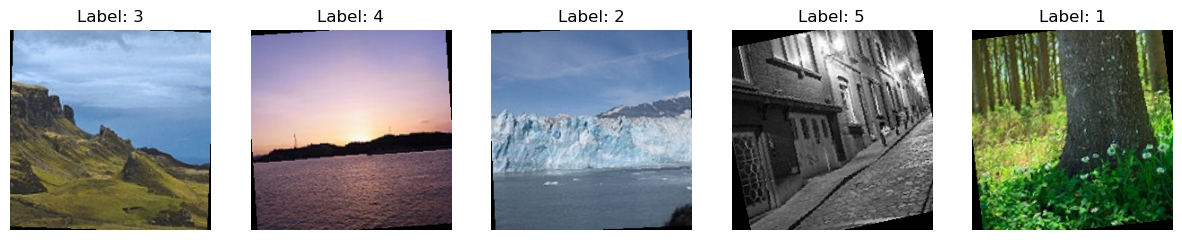

In [8]:
visualize_augmentations(train_loader)


## Створення простої згорткової нейронної мережі (CNN)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self._calculate_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def _calculate_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        x = self.conv1(dummy_input)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool2(x)
        self.flattened_size = x.numel()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = x.view(-1, self.flattened_size)

        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
num_classes = len(train_path.ls())
simple_snn = SimpleCNN(num_classes=num_classes)
simple_snn = simple_snn.to(device)


## Створення моделі ResNet18

In [11]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18 = resnet18.to(device)


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Оптимізатори

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_snn = optim.Adam(simple_snn.parameters(), lr=0.00075, weight_decay=1e-4)
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.0001)


## Побудова допоміжних функцій для навчання моделей

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy
    

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path="best_model.pth"):
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.08, patience=2, verbose=True)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved Best Model at Epoch {epoch+1} with Validation Accuracy: {val_accuracy:.2f}%")

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

        scheduler.step(val_accuracy)

    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.2f}%")
    return history


In [15]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Навчання та оцінка моделей


Training SimpleCNN...


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved Best Model at Epoch 1 with Validation Accuracy: 51.94%
Epoch [1/30]
Train Loss: 1.6212, Train Accuracy: 41.92%
Validation Loss: 1.1168, Validation Accuracy: 51.94%
--------------------------------------------------
Epoch [2/30]
Train Loss: 1.2706, Train Accuracy: 46.74%
Validation Loss: 1.1265, Validation Accuracy: 50.80%
--------------------------------------------------
Saved Best Model at Epoch 3 with Validation Accuracy: 63.80%
Epoch [3/30]
Train Loss: 1.2217, Train Accuracy: 47.81%
Validation Loss: 0.9826, Validation Accuracy: 63.80%
--------------------------------------------------
Saved Best Model at Epoch 4 with Validation Accuracy: 64.48%
Epoch [4/30]
Train Loss: 1.1726, Train Accuracy: 49.88%
Validation Loss: 0.9363, Validation Accuracy: 64.48%
--------------------------------------------------
Saved Best Model at Epoch 5 with Validation Accuracy: 65.69%
Epoch [5/30]
Train Loss: 1.1359, Train Accuracy: 52.17%
Validation Loss: 0.9005, Validation Accuracy: 65.69%
-------

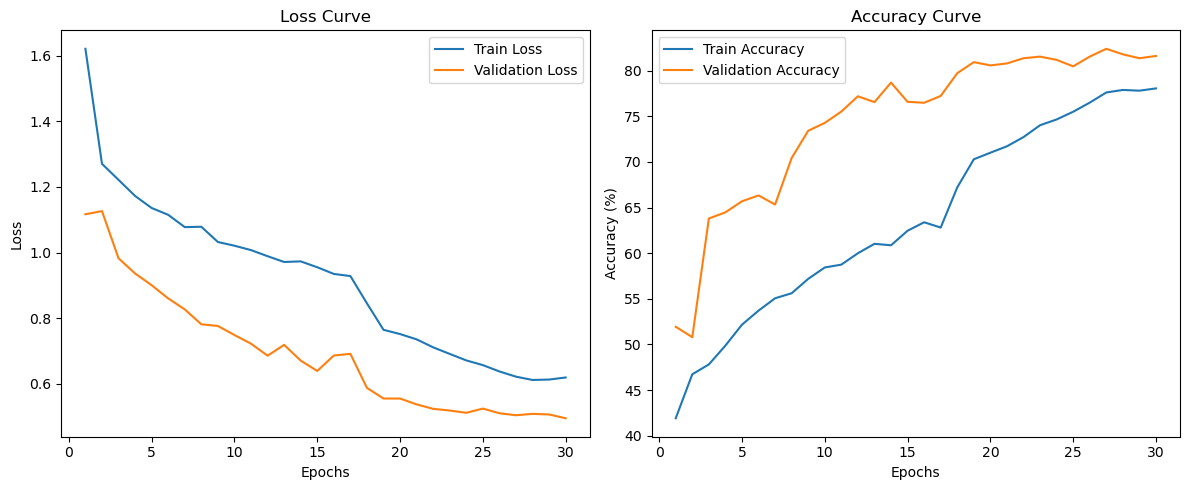


Training ResNet18...
Saved Best Model at Epoch 1 with Validation Accuracy: 75.35%
Epoch [1/30]
Train Loss: 1.3327, Train Accuracy: 55.49%
Validation Loss: 0.9533, Validation Accuracy: 75.35%
--------------------------------------------------
Saved Best Model at Epoch 2 with Validation Accuracy: 83.36%
Epoch [2/30]
Train Loss: 0.8270, Train Accuracy: 78.73%
Validation Loss: 0.6556, Validation Accuracy: 83.36%
--------------------------------------------------
Saved Best Model at Epoch 3 with Validation Accuracy: 85.82%
Epoch [3/30]
Train Loss: 0.6432, Train Accuracy: 83.00%
Validation Loss: 0.5439, Validation Accuracy: 85.82%
--------------------------------------------------
Saved Best Model at Epoch 4 with Validation Accuracy: 85.89%
Epoch [4/30]
Train Loss: 0.5515, Train Accuracy: 84.31%
Validation Loss: 0.4823, Validation Accuracy: 85.89%
--------------------------------------------------
Saved Best Model at Epoch 5 with Validation Accuracy: 87.25%
Epoch [5/30]
Train Loss: 0.4933, 

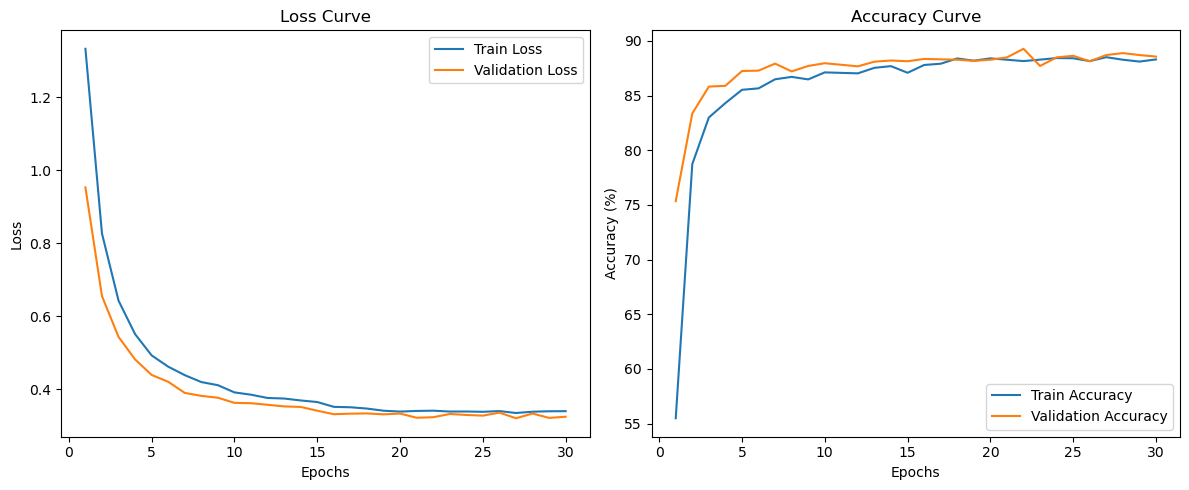

In [16]:
print("\nTraining SimpleCNN...")
history_snn = train_model(simple_snn, train_loader, val_loader, criterion, optimizer_snn, num_epochs=30, device=device, save_path="simple_cnn_best.pth")
plot_metrics(history_snn)

print("\nTraining ResNet18...")
history_resnet = train_model(resnet18, train_loader, val_loader, criterion, optimizer_resnet, num_epochs=30, device=device, save_path="resnet18_best.pth")
plot_metrics(history_resnet)

In [17]:
simple_snn = SimpleCNN(num_classes=6).to(device)
simple_snn.load_state_dict(torch.load("simple_cnn_best.pth", weights_only=True))
simple_snn.eval()

resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 6)
resnet18.load_state_dict(torch.load("resnet18_best.pth", weights_only=True))
resnet18 = resnet18.to(device)
resnet18.eval()

print("Models loaded successfully.")


Models loaded successfully.


In [18]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=next(model.parameters()).dtype)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, report, cm


In [19]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [20]:
print("\nEvaluating SimpleCNN on Test Dataset...")
accuracy_snn, f1_snn, report_snn, cm_snn = evaluate_model(simple_snn, test_loader, device)
print(f"SimpleCNN Accuracy: {accuracy_snn:.2f}")
print(f"SimpleCNN F1-score: {f1_snn:.2f}")
print("Classification Report:\n", report_snn)

print("\nEvaluating ResNet18 on Test Dataset...")
accuracy_resnet, f1_resnet, report_resnet, resnet_cm = evaluate_model(resnet18, test_loader, device)
print(f"ResNet18 Accuracy: {accuracy_resnet:.2f}")
print(f"ResNet18 F1-score: {f1_resnet:.2f}")
print("Classification Report:\n", report_resnet)



Evaluating SimpleCNN on Test Dataset...
SimpleCNN Accuracy: 0.83
SimpleCNN F1-score: 0.83
Classification Report:
               precision    recall  f1-score   support

   buildings       0.78      0.84      0.81       437
      forest       0.95      0.96      0.95       474
     glacier       0.82      0.79      0.80       553
    mountain       0.75      0.75      0.75       525
         sea       0.83      0.80      0.81       510
      street       0.87      0.85      0.86       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000


Evaluating ResNet18 on Test Dataset...
ResNet18 Accuracy: 0.90
ResNet18 F1-score: 0.90
Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.91      0.89       437
      forest       0.97      0.99      0.98       474
     glacier       0.86      0.85      0.86       553
    mountain 

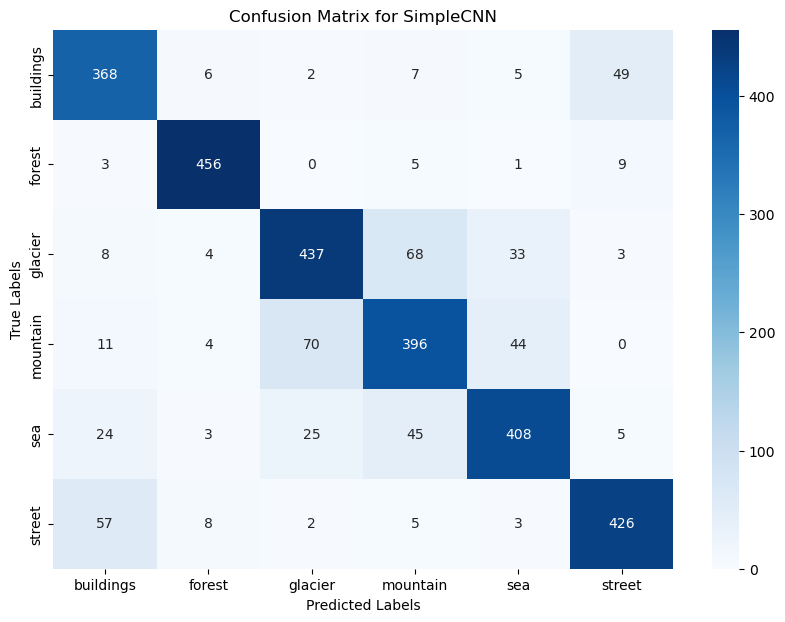

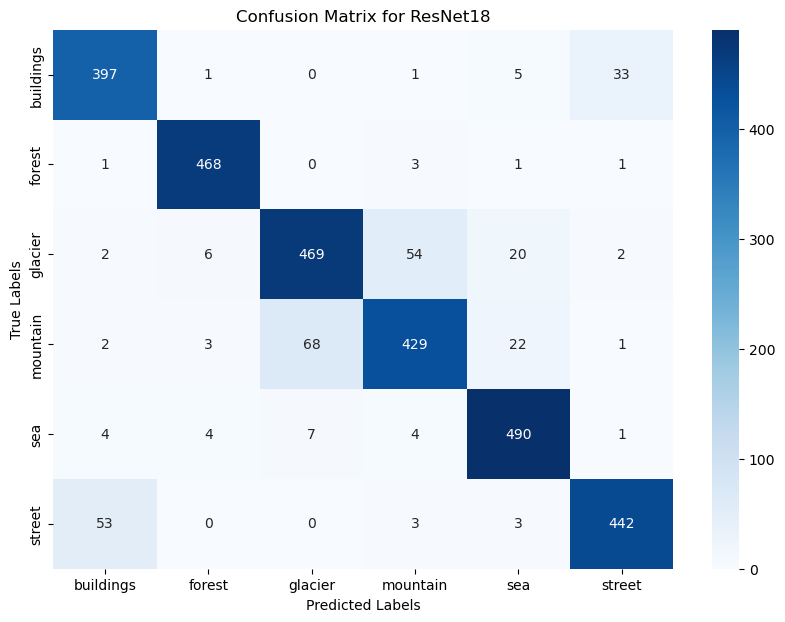

In [21]:
plot_confusion_matrix(cm_snn, test_loader.dataset.classes, "SimpleCNN")

plot_confusion_matrix(resnet_cm, test_loader.dataset.classes, "ResNet18")

### **Покращення продуктивності SimpleCNN**

---

#### **Мета**
Основною метою цього експерименту було навчити та оптимізувати згорткову нейронну мережу (CNN) `SimpleCNN` для багатокласової класифікації та систематично покращувати її продуктивність через ітеративні вдосконалення. Основна увага приділялася збалансуванню метрик навчання та валідації, а також досягненню високої узагальненості на тестовому наборі даних.

---

#### **Матеріали та інструменти**
- **Мова програмування**: Python  
- **Фреймворк для глибокого навчання**: PyTorch  
- **Набір даних**: Набір зображень для багатокласової класифікації з такими класами: Будівлі, Ліс, Льодовик, Гори, Море, Вулиця.  
- **Метрики оцінювання**:  
  - Точність (Accuracy)  
  - Precision, Recall, F1-міра (для кожного класу та в цілому)  
- **Обладнання**: Система з підтримкою GPU для прискореного навчання.

---

#### **Методологія**

1. **Початкове налаштування**:
   - Реалізовано `SimpleCNN` з трьома згортковими шарами, Max-Pooling, та повнозв’язними шарами.
   - Вхідний розмір зображення: 224x224.

2. **Базова модель**:
   - Проведено навчання початкової `SimpleCNN` без удосконалень.
   - Спостерігалося перенавчання з помітним розривом між результатами навчання та валідації.

3. **Ітеративні покращення**:
   - **Додавання аугментації даних**: Застосовано ColorJitter і гаусівський шум, але це не дало позитивних результатів.
   - **Додавання планувальника (Scheduler)**: Реалізовано `ReduceLROnPlateau` для динамічного регулювання швидкості навчання, що покращило результати, але перенавчання все ще залишалося.
   - **Збільшення Dropout**: Dropout у повнозв’язних шарах збільшено до **0.5**, що зменшило перенавчання, але спочатку погіршило результати.
   - **Тонке налаштування швидкості навчання**: Випробувано різні значення, оптимальною виявилася **0.00075**, що призвело до більш плавної збіжності.
   - **Додавання Weight Decay**: Уведено `weight_decay=1e-4` в оптимізатор Adam, що покращило метрики валідації, зменшивши розмір ваг.
   - **Збільшення ємності моделі**: Розширено кількість фільтрів у згорткових шарах, що дозволило моделі краще витягувати ознаки та підвищити продуктивність на тестовому наборі.

4. **Налаштування навчання**:
   - Оптимізатор: Adam з `lr=0.00075` та `weight_decay=1e-4`.  
   - Планувальник: ReduceLROnPlateau (factor=0.1, patience=3).  
   - Розмір батчу: 32.  
   - Кількість епох: 30.

---

#### **Результати**

1. **Прогрес навчання**:
   - Точність валідації зросла з **51.94% (Епоха 1)** до **82.40% (Епоха 27)**.
   - Втрати навчання та точність стабілізувалися після **27-ї епохи**, що вказує на достатню збіжність.
   - Метрики валідації демонструють мінімальні коливання, що підтверджує зменшення перенавчання завдяки регуляризації.

2. **Результати тестування**:
   - **Загальна точність (Accuracy)**: 83%  
   - **Загальна F1-міра**: 0.83  
   - **Результати по класах**:

| **Клас**    | **Precision** | **Recall** | **F1-міра** | **Кількість** |
|--------------|---------------|------------|--------------|---------------|
| Будівлі      | 0.78          | 0.84       | 0.81         | 437           |
| Ліс          | 0.95          | 0.96       | 0.95         | 474           |
| Льодовик     | 0.82          | 0.79       | 0.80         | 553           |
| Гори         | 0.75          | 0.75       | 0.75         | 525           |
| Море         | 0.83          | 0.80       | 0.81         | 510           |
| Вулиця       | 0.87          | 0.85       | 0.86         | 501           |

   - **Середнє по макро-показникам**:
     - Precision: 0.83, Recall: 0.83, F1-міра: 0.83.  
   - **Зважене середнє**:
     - Precision: 0.83, Recall: 0.83, F1-міра: 0.83.

---

#### **Обговорення**

1. **Сильні сторони**:
   - Модель демонструє збалансовану продуктивність для більшості класів, з мінімальними компромісами між precision і recall.
   - Успішно зменшено перенавчання завдяки Dropout, Weight Decay та збільшенню ємності моделі.
   - Метрики валідації та тестування показали послідовне покращення на всіх етапах.

2. **Слабкі сторони**:
   - **Гори** та **Льодовики** продемонстрували нижчі F1-міри (0.75 та 0.80 відповідно), що може бути зумовлено схожими візуальними ознаками.
   - Продуктивність стабілізувалася після **27-ї епохи**, що вказує на обмеження поточної архітектури.

3. **Проблеми з аугментацією**:
   - Застосована аугментація даних не покращила результати, ймовірно через вже достатню різноманітність даних.

4. **Ключові інсайти**:
   - Найбільший вплив мали збільшення ємності моделі та тонке налаштування гіперпараметрів.
   - Регуляризація через Weight Decay і Dropout допомогла покращити метрики валідації та зменшити розрив між навчанням і валідацією.

---

Остаточна модель SimpleCNN досягла точності **83%** та F1-міри **0.83** на тестовому наборі, демонструючи збалансовану та надійну продуктивність. Незважаючи на це, виклики залишаються у класифікації схожих класів, таких як Гори та Льодовики. 

### **Навчання ResNet18**

---

#### **Мета**
Навчити та оцінити попередньо навчену модель ResNet18 на багатокласовому наборі даних для класифікації зображень. Метою було використати підхід трансферного навчання для досягнення високої продуктивності з мінімальним налаштуванням.

---

#### **Матеріали та інструменти**
- **Мова програмування**: Python  
- **Фреймворк**: PyTorch  
- **Попередньо навчена модель**: ResNet18 з бібліотеки `torchvision.models`.  
- **Набір даних**: Багатокласовий набір даних із категоріями: Будівлі, Ліс, Льодовик, Гори, Море, Вулиця.  
- **Метрики**: Точність, Precision, Recall, F1-міра.

---

#### **Методологія**

1. **Налаштування моделі**:
   - Завантажено ResNet18, попередньо навчений на ImageNet.
   - Заміщено фінальний повнозв’язний шар для відповідності кількості цільових класів.
   - **Заморожено базові шари**: Усі шари, окрім фінального повнозв’язного, залишені без змін для запобігання зайвих оновлень ваг.
   - **Оптимізатор**: Adam із швидкістю навчання `0.0001`.

2. **Налаштування навчання**:
   - Розмір батчу: 32.  
   - Кількість епох: 30.  
   - Планувальник: `ReduceLROnPlateau` з базовими параметрами (factor=0.1, patience=3).

---

#### **Результати**

1. **Результати навчання та валідації**:
   - **Найкраща валідаційна точність**: 89.28% (Епоха 22).  
   - Валідаційна точність стрімко зростала на ранніх епохах і стабілізувалася ближче до кінця.  
   - Криві навчання та валідації показують **відмінну генералізацію** без ознак перенавчання.

2. **Результати тестування**:
   - **Точність**: 90%.  
   - **F1-міра**: 0.90.  
   - **Результати по класах**:

| **Клас**    | **Precision** | **Recall** | **F1-міра** | **Кількість** |
|--------------|---------------|------------|--------------|---------------|
| Будівлі      | 0.86          | 0.91       | 0.89         | 437           |
| Ліс          | 0.97          | 0.99       | 0.98         | 474           |
| Льодовик     | 0.86          | 0.85       | 0.86         | 553           |
| Гори         | 0.87          | 0.82       | 0.84         | 525           |
| Море         | 0.91          | 0.96       | 0.93         | 510           |
| Вулиця       | 0.92          | 0.88       | 0.90         | 501           |

   - **Середнє по макро-показникам**:
     - Precision: 0.90, Recall: 0.90, F1-міра: 0.90.  
   - **Зважене середнє**:
     - Precision: 0.90, Recall: 0.90, F1-міра: 0.90.

---

#### **Обговорення**

1. **Сильні сторони**:
   - **Тестова точність (90%)** та F1-міра (0.90) демонструють високу продуктивність для всіх класів.  
   - **Ліс** та **Море** досягли майже ідеальних F1-мір, що свідчить про відмінне витягування ознак для цих класів.  
   - Мінімальне перенавчання завдяки заморожуванню базових шарів і використанню попередньо навченої основи.

2. **Слабкі сторони**:
   - **Гори** та **Льодовики** показали трохи нижчі F1-міри (0.84 та 0.86 відповідно), імовірно через схожі ознаки.
   - Продуктивність валідації стабілізувалася на ранніх етапах, що вказує на можливість подальшого налаштування.

---

Попередньо навчена модель ResNet18 досягла виняткової продуктивності з мінімальними налаштуваннями та навчанням. Її сильна генералізація та висока точність роблять її надійним вибором для цієї задачі класифікації. Це підтверджує ефективність трансферного навчання для завдань, де витягування ознак відіграє ключову роль.

### **Порівняння та Висновки**

1. Модель ResNet18 перевершила SimpleCNN як за точністю валідації (**89.28%**) і тестування (**90%**), так і за збалансованістю метрик, тоді як SimpleCNN досягла **82.40%** точності валідації та **83%** точності на тестовому наборі.  
2. ResNet18 продемонструвала сильнішу генералізацію, з кращими метриками (precision, recall, F1-міра) для всіх класів, особливо для **Лісу** та **Моря**, де F1-міра досягла **0.98** та **0.93** відповідно.  
3. SimpleCNN мала труднощі з класифікацією складних класів, таких як **Гори** та **Льодовик**, із F1-мірою **0.75–0.80**, тоді як ResNet18 покращила ці показники до **0.84** та **0.86**.  
4. ResNet18 отримала перевагу завдяки трансферному навчанню, використовуючи попередньо навчені ваги ImageNet для витягування ознак, у той час як SimpleCNN навчалася повністю з нуля.  
5. Навчання SimpleCNN вимагало значних налаштувань (додавання Dropout, Weight Decay, коригування швидкості навчання та збільшення ємності моделі) для досягнення прийнятної продуктивності.  
6. ResNet18 із замороженими базовими шарами мінімізувала перенавчання, що підтверджується близькістю кривих навчання та валідації, тоді як SimpleCNN демонструвала легке перенавчання на ранніх етапах.  
7. SimpleCNN стала чудовим інструментом для навчання принципів побудови CNN та оптимізації гіперпараметрів, забезпечуючи цінний освітній досвід.  
8. ResNet18 швидше сходилася та демонструвала високу продуктивність уже на ранніх епохах, тоді як SimpleCNN потребувала більше епох і налаштувань для стабілізації метрик.  
9. Хоча ResNet18 явно перевершує SimpleCNN у стабільності та продуктивності, SimpleCNN пропонує більший контроль над дизайном архітектури, що може бути критичним для спеціалізованих завдань.  
10. Обидві моделі демонстрували труднощі з класифікацією **Гір** і **Льодовиків**, що вказує на необхідність додаткової аугментації даних або покращення ознак, але ResNet18 все ж показала кращі результати для цих категорій.  
11. Завдяки використанню попередньо навчених ознак ResNet18 ідеально підходить для розгортання у реальних задачах, тоді як SimpleCNN краще підходить для навчальних і експериментальних цілей.  
12. Загалом, ResNet18 є рекомендованою моделлю для продуктивного використання через її високу точність та стабільність, тоді як SimpleCNN залишається цінним інструментом для вивчення принципів CNN.